In [1]:
# get data
import numpy as np
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide()
fs_peptide.cache()

fs_peptide already is cached


C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import tempfile
import os
os.chdir(tempfile.mkdtemp())

In [3]:
fs_peptide.data_dir

'C:\\Users\\Christian\\msmbuilder_data\\fs_peptide'

In [4]:
# Open trajectories

from msmbuilder.dataset import dataset
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)
print("{} trajectories".format(len(xyz)))
# msmbuilder does not keep track of units! You must keep track of your
# data's timestep
to_ns = 0.5
print("with length {} ns".format(set(len(x)*to_ns for x in xyz)))

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)

C:\Users\Christian\Anaconda2\envs\py36\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


28 trajectories
with length {500.0} ns


In [5]:
#featurization

from msmbuilder.featurizer import DihedralFeaturizer
#featurizer = DihedralFeaturizer(types=['phi', 'psi']) # Default setting
featurizer = DihedralFeaturizer(types=['phi', 'psi'], sincos=False)
diheds = xyz.fit_transform_with(featurizer, 'diheds/', fmt='dir-npy')
print(xyz[0].xyz.shape)
print(diheds[0].shape)


(1000, 264, 3)
(1000, 42)


In [6]:
_, num_features = diheds[0].shape
pre_X = [np.reshape(traj, (traj.shape[0],num_features)) for traj in diheds]
X = np.concatenate(pre_X)
folder = 'C:\\Users\\Christian\\Documents\\GitHub\\Protein_Dynamics_TJ\\MSM_Builder_Test\\PC_Data\\fspeptide\\sim_datasets\\'
np.savetxt(folder + 'raw_phi_psi.csv', X, delimiter=',')

In [7]:
#tICA

from msmbuilder.decomposition import tICA
tica_model = tICA(lag_time=2, n_components=4)
# fit and transform can be done in seperate steps:
tica_model = diheds.fit_with(tica_model)
tica_trajs = diheds.transform_with(tica_model, 'ticas/', fmt='dir-npy')

print(diheds[0].shape)
print(tica_trajs[0].shape)

(1000, 42)
(1000, 4)


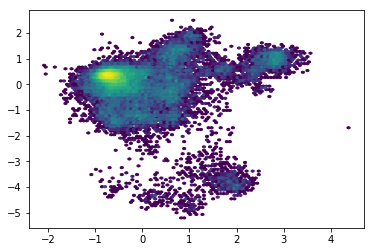

In [8]:
#histogram

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
txx = np.concatenate(tica_trajs)
plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')

In [9]:
#clustering

from msmbuilder.cluster import MiniBatchKMeans

clusterer = MiniBatchKMeans(n_clusters=97)
clustered_trajs = tica_trajs.fit_transform_with(clusterer, 'kmeans/', fmt='dir-npy')

print(tica_trajs[0].shape)
print(clustered_trajs[0].shape)

(1000, 4)
(1000,)


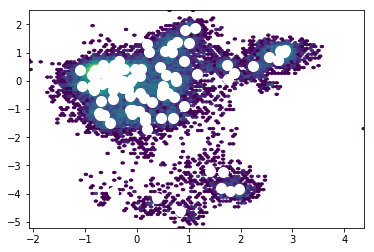

In [10]:
#show cluster

plt.hexbin(txx[:,0], txx[:,1], bins='log', mincnt=1, cmap='viridis')
plt.scatter(clusterer.cluster_centers_[:,0],
            clusterer.cluster_centers_[:,1], 
            s=100, c='w')

In [11]:
#msm builder

from msmbuilder.msm import MarkovStateModel
from msmbuilder.utils import dump
msm = MarkovStateModel(lag_time=2, n_timescales=20, ergodic_cutoff='on')
msm.fit(clustered_trajs)

MSM contains 1 strongly connected component above weight=0.50. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=2, n_timescales=20,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

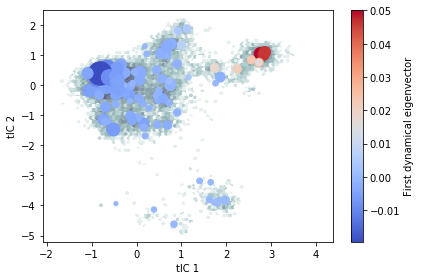

In [12]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=1e4 * msm.populations_,       # size by population
            c=msm.left_eigenvectors_[:, 1], # color by eigenvector
            cmap="coolwarm") 
plt.colorbar(label='First dynamical eigenvector')
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.tight_layout()

In [15]:
from msmbuilder.tpt import mfpts 
mfpt_matrix = mfpts(msm)
print(mfpt_matrix.shape)

(97, 97)


In [14]:
np.savetxt('C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\cluster_assignments.csv', np.concatenate(clustered_trajs), delimiter=',')
np.savetxt('C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\\raw_XYZ_28000.csv', X, delimiter=',')
import msmbuilder.utils as msmutils
msmutils.dump(msm, 'C:\Users\minch_000\Documents\TJ_data\\fspeptide\msm_out\msm.pkl')


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-14-70ebf0ea2c52>, line 1)

In [ ]:
idx = np.argmax(msm.populations_)
max_pop = msm.populations_[idx]
print idx, max_pop

In [ ]:

plt.subplots(figsize=(3,5))
plt.hlines(msm.timescales_ * to_ns, 0, 1, color='b')
plt.yscale('log')
plt.xticks([])
plt.ylabel("Timescales / ns", fontsize=18)
plt.tight_layout()

In [ ]:
#macrostate model

from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=4)
macro_trajs = pcca.transform(clustered_trajs)

In [ ]:
plt.hexbin(txx[:, 0], txx[:, 1], bins='log', mincnt=1, cmap="bone_r")
plt.scatter(clusterer.cluster_centers_[msm.state_labels_, 0],
            clusterer.cluster_centers_[msm.state_labels_, 1],
            s=50,
            c=pcca.microstate_mapping_,
)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')

In [ ]:
# Get video of 1st Tica

# First organize data into rows
temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X) # Each row contains the raw data of the corresponding frame

In [ ]:
import mdtraj as md

first_tICA = txx[:,0]
idx_sort = first_tICA.argsort()[-len(first_tICA):][::-1]
traj = idx_sort[::10]

tICA_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
md_traj = md.Trajectory(tICA_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
filename = 'first_tICA.xtc'
md_traj.save_xtc('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\\MSM_Builder_Test\\Eigen_Data\\' + filename)

In [ ]:
#assigns every frame to a cluster

#Cluster locations: clusterer.cluster_centers_
#Frame locations: tica_trajs[0].shape

def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

msm_labels = msm.state_labels_

cluster_location = []
for traj in tica_trajs:
    for frame in traj:
        error = np.linalg.norm(clusterer.cluster_centers_ - frame, axis=1)
        idx = error.argsort()[:4]
        idx = intersect(idx, msm_labels)
        cluster_location.append(idx[0])

In [ ]:
#Now we have the transition matrix and frame cluster location

#print msm.transmat_
#print cluster_location[1:1000]

In [ ]:
import mdtraj as md
file_location = "C:\\Users\\Christian\\Documents\\GitHub\\Protein_Dynamics_TJ\\MSM_Builder_Test\\Data\\"
t = md.load(file_location + "aligned_xyz_reconst.dcd", top=file_location + "fs-peptide.pdb")

t2 = []
for idx, trajectories in enumerate(xyz):
    if idx == 0:
        t2 = trajectories
    if idx != 0:
        t2 = t2.join(trajectories)
        

# print t.xyz.shape
# print xyz[0].xyz.shape
temp = xyz[0]
reference_frame = temp.slice(0, copy=True)

#t1 contains the linear path
#t2 contains all the frames
t.superpose(reference_frame)
t2.superpose(reference_frame)

In [ ]:
true_frame_order = []
i = 0
for frame in t:
    rmsds = md.rmsd(t2, frame)
    true_frame_order.append(rmsds.argmin())
print true_frame_order

In [ ]:
#true_frame_order
#cluster_location

markov_traj = []
for num in true_frame_order:
    markov_traj.append(cluster_location[num])

print markov_traj

In [ ]:
#check if reasonable result

for idx in range(0, len(markov_traj) - 1):
    first = idx
    second = idx + 1
    #print msm.transmat_[markov_traj[first], markov_traj[second]]

print lv.shape
print fs_peptide.data_dir
print np.argmax(np.array(msm.populations_))

In [ ]:
v = msm.eigenvalues_
lv = msm.left_eigenvectors_
idx_sort = msm.populations_.argsort()[-len(msm.populations_):][::-1]
lv = lv[idx_sort,:]
v.dump('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\v_fs_original_stride_10.dat')
lv.dump('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\lv_fs_original_stride_10.dat')

In [ ]:
lv = msm.left_eigenvectors_
idx_sort = msm.populations_.argsort()[-len(msm.populations_):][::-1]
lv = lv[idx_sort,:]

lv_og = np.load('C:\Users\Christian\Documents\GitHub\Protein_Dynamics_TJ\MSM_Builder_Test\Eigen_Data\\lv_fs_original_stride_10.dat')
print np.dot(lv_og[:,0], lv[:,0])/(np.linalg.norm(lv_og[:,0])*np.linalg.norm(lv[:,0]))

In [ ]:
#Plotting dot product of eigenvectors

import numpy as np
import scipy.linalg as linalg


cutoff = 0.01
y = []
x = range(1,21)
for n in x:
    transmat_cut = np.zeros(msm.transmat_.shape)
    for i in range(msm.transmat_.shape[0]):
        v = msm.transmat_[i,:]
        temp = np.zeros(v.shape)
        #idx = np.where(v > cutoff)[0]
        idx = v.argsort()[-n:][::-1]
        for j in idx:
            temp[j] = v[j]
        transmat_cut[i,:] = temp
    for i in range(msm.transmat_.shape[0]):
        transmat_cut[i,:] = transmat_cut[i,:]/sum(transmat_cut[i,:])

    w, lv, rv = linalg.eig(transmat_cut, left=True)
    idx = w.argsort()[::-1]
    w = w[idx]
    lv = lv[:,idx]
    rv = rv[:,idx]

    result = []
    for i in range(len(msm.eigenvalues_)):
        a = lv[:,i]
        b = msm.left_eigenvectors_[:,i]
        result.append(abs(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))))
    print n, result[0:2]
    y.append(result)
y = np.array(y)
import matplotlib.pyplot as plt
plt.plot(x,y[:,0], label='stationary')
plt.plot(x,y[:,1], label='1st dynamical')
plt.plot(x,y[:,2], label='2nd dynamical')
plt.legend(loc='lower right')
plt.ylabel('some numbers')
plt.show()